In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

2025-06-29 17:40:21.607167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751218821.830682      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751218821.896309      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [3]:
from tensorflow.keras.models import load_model


gru = load_model('/kaggle/input/demomodel-temp-mois/tensorflow2/default/3/gru-nh4-h2s.h5')
lstm = load_model('/kaggle/input/demomodel-temp-mois/tensorflow2/default/3/lstm-nh4-h2s.h5')
import joblib

# Load the scaler
scaler = joblib.load('//kaggle/input/demomodel-temp-mois/tensorflow2/default/3/nh4_h2s_scaler.joblib')


2025-06-29 17:40:35.447281: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
df = pd.read_csv(
    '/kaggle/input/tempura/Dataset_NH3_and_H2S_March_to_April.csv',
    sep=',',
    parse_dates=['Timestamp'],
    low_memory=False,
    na_values=['nan', '?'],
    index_col='Timestamp'
)

df =df.iloc[:,:2]
n_in=24
df=scaler.transform(df)
df=series_to_supervised(df,n_in,1)
df=df.values
size=df.shape[0]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
x=df[:,:n_in*2].reshape((size, n_in, 2))
y=df[:,n_in*2:]

In [6]:
gru_pred=gru.predict(x)
lstm_pred=lstm.predict(x)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step


In [7]:
gru_pred

array([[0.30702224, 0.18087131],
       [0.30883494, 0.18225035],
       [0.3107404 , 0.18369271],
       ...,
       [0.20091644, 0.12482034],
       [0.20120025, 0.12484022],
       [0.20144176, 0.12483673]], dtype=float32)

In [8]:
lstm_pred

array([[0.35015634, 0.21587135],
       [0.35229754, 0.21756089],
       [0.35445297, 0.21920724],
       ...,
       [0.23854905, 0.1537101 ],
       [0.23867919, 0.15365028],
       [0.23876509, 0.15358263]], dtype=float32)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compare_pred_true_tables(pred_table, true_table, time_steps_to_plot,
                              title="Predicted vs True Values",
                              labels=("NH3", "H2S"),
                              scaler=None,
                              figsize=(16, 6),
                              linewidth=2,
                              fontsize=14):

    pred_table = np.array(pred_table)
    true_table = np.array(true_table)


    feature_names = ["NH3", "H2S"]
    dummy_pred = np.zeros((pred_table.shape[0], scaler.n_features_in_))
    dummy_true = np.zeros((true_table.shape[0], scaler.n_features_in_))
    dummy_pred[:, :pred_table.shape[1]] = pred_table
    dummy_true[:, :true_table.shape[1]] = true_table
    for i, name in enumerate(feature_names):
        y_true = dummy_true[:, i]
        y_pred = dummy_pred[:, i]

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        rrse = np.sqrt(np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
        print(f"{name} Metrics:")
        print(f"  MAE :  {mae:.4f}")
        print(f"  MSE :  {mse:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  RRSE:  {rrse:.4f}")

    pred_table = scaler.inverse_transform(dummy_pred)[:, :pred_table.shape[1]]
    true_table = scaler.inverse_transform(dummy_true)[:, :true_table.shape[1]]
    # Time axis ( hourly)
    time_steps = np.arange(time_steps_to_plot)

    # Set global style
    plt.style.use('seaborn-whitegrid')

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, fontsize=fontsize + 2, weight='bold')

    # Color palette: [true colors, predicted colors]
    true_colors = ['#1b9e77', '#7570b3']      # green, purple
    pred_colors = ['#e41a1c', '#d95f02']      # red, orange

    for i, ax in enumerate(axes):
        ax.plot(time_steps, true_table[:time_steps_to_plot, i],
                label=f"True {labels[i]}",
                color=true_colors[i], linewidth=linewidth)

        ax.plot(time_steps, pred_table[:time_steps_to_plot, i],
                label=f"Predicted {labels[i]}",
                color=pred_colors[i], linestyle='--', linewidth=linewidth)

        ax.set_title(f"{labels[i]} Comparison", fontsize=fontsize, weight='semibold')
        ax.set_xlabel("Time Step (Hourly)", fontsize=fontsize)
        ax.set_ylabel(labels[i], fontsize=fontsize)
        ax.tick_params(axis='both', labelsize=fontsize - 2)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=fontsize - 2, loc="upper right")
        ax.set_xlim([0, time_steps_to_plot])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


NH3 Metrics:
  MAE :  0.0052
  MSE :  0.0000
  RMSE:  0.0061
  RRSE:  0.0180
H2S Metrics:
  MAE :  0.0110
  MSE :  0.0002
  RMSE:  0.0144
  RRSE:  0.0518


/tmp/ipykernel_13/354688129.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


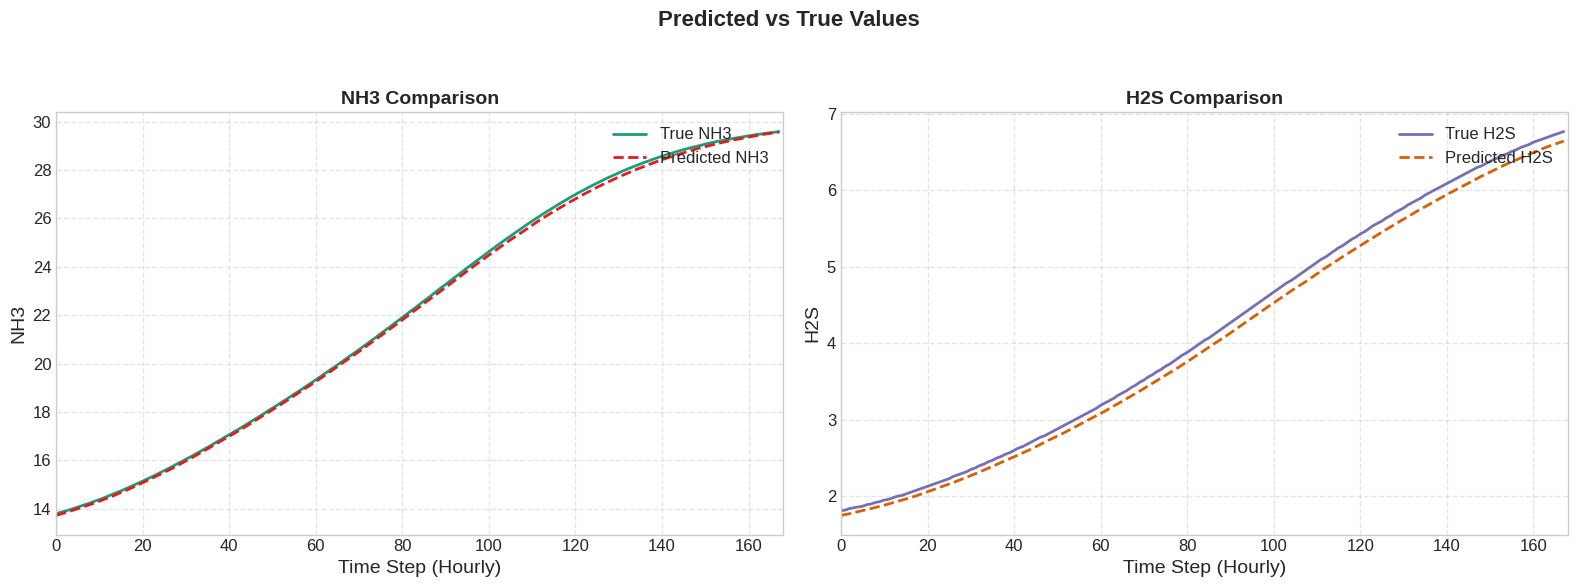

In [10]:
compare_pred_true_tables(lstm_pred,y,24*7,scaler=scaler)

NH3 Metrics:
  MAE :  0.0280
  MSE :  0.0010
  RMSE:  0.0324
  RRSE:  0.0951
H2S Metrics:
  MAE :  0.0287
  MSE :  0.0010
  RMSE:  0.0314
  RRSE:  0.1131


/tmp/ipykernel_13/354688129.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


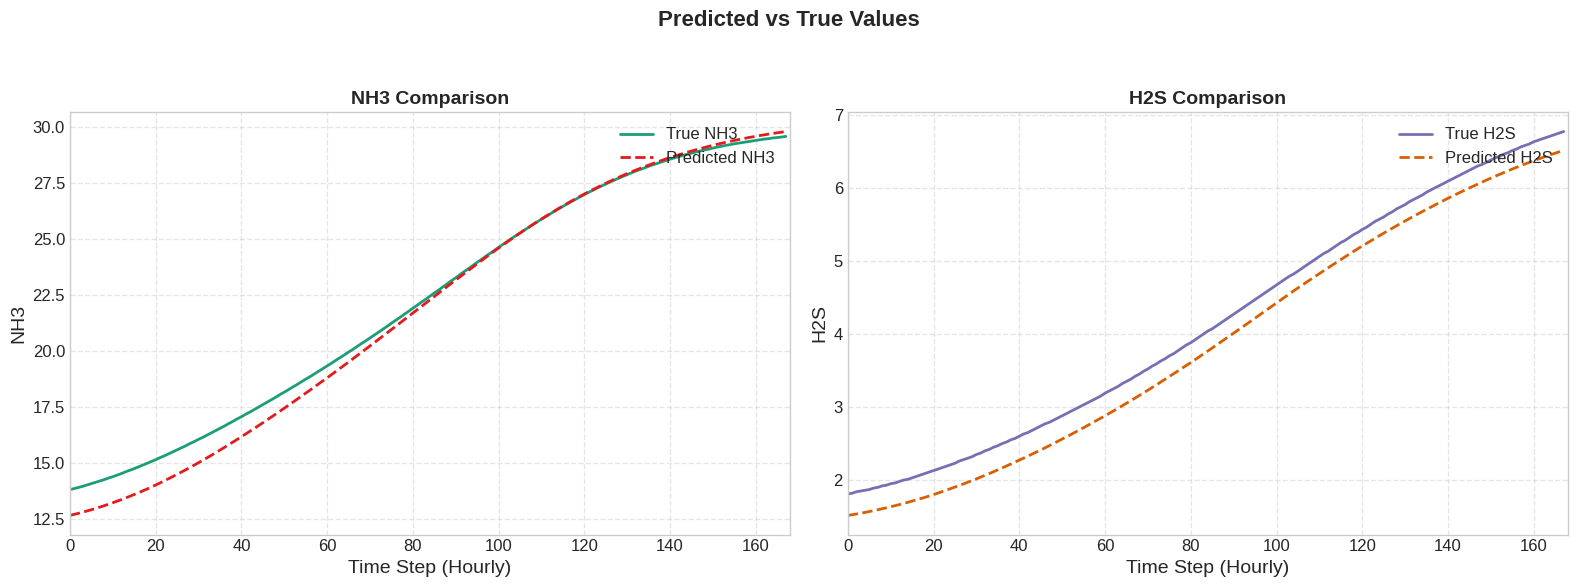

In [11]:
compare_pred_true_tables(gru_pred,y,24*7,scaler=scaler)